# Implementation of Vanilla GANs model
Reference: https://arxiv.org/pdf/1406.2661.pdf

In [121]:
# Note, this example concentrate on implementing the mechanics of the training process of GAN system
# we use the most simple neural model - dense linear layers

In [122]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

In [123]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

In [124]:
import numpy as np
import datetime
import os, sys

In [125]:
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

In [126]:
MODEL_NAME = 'vanilla-GAN-100-epoch-symetric'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [127]:
# generate a sample of fake images by sampling the noise
def get_sample_image(G, n_noise):
    z = torch.randn(100, n_noise).to(DEVICE)
    y_hat = G(z).view(100, 28, 28) # (100, 28, 28)
    result = y_hat.cpu().data.numpy()
    img = np.zeros([280, 280])
    for j in range(10):
        img[j*28:(j+1)*28] = np.concatenate([x for x in result[j*10:(j+1)*10]], axis=-1)
    return img

In [128]:
# generate a sample of fake images by sampling the noise and mark images discarded by discriminator as fakes with reversed colours
def get_sample_image_with_discriminator_discards(G, D, n_noise):
    G.eval()
    D.eval()
    z = torch.randn(100, n_noise).to(DEVICE)
    x_star = G(z)
    y_hat = x_star.view(100, 28, 28) # (100, 28, 28)
    result = y_hat.cpu().data.numpy()
    z_outputs = D(x_star)
    predicted = z_outputs.round()
    img_org = np.zeros([280, 280])
    for j in range(10):
        img_org[j*28:(j+1)*28] = np.concatenate([x for x in result[j*10:(j+1)*10]], axis=-1)
    for k in range(len(predicted)):
      if predicted[k] == 0.0:
        for i in range(28):
          for j in range(28):
              result[k][i][j] *= -1
    img = np.zeros([280, 280])
    for j in range(10):
        img[j*28:(j+1)*28] = np.concatenate([x for x in result[j*10:(j+1)*10]], axis=-1)
    return img#, img_org

## Models

- vanilla GAN- simplest possible fully connected model

no convolutional layers and more complex stuff

- DC GAN - Deep Convolutional GAN

In [129]:
class Discriminator(nn.Module):
    def __init__(self, input_size=784, num_classes=1):
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, num_classes),
            nn.Sigmoid(),
        )

    def forward(self, x):
        y_ = x.view(x.size(0), -1)
        y_ = self.layer(y_)
        return y_

In [130]:
class Generator(nn.Module):
    def __init__(self, input_size=100, num_classes=784):
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, num_classes),
            nn.Tanh()
        )

    def forward(self, x):
        y_ = self.layer(x)
        y_ = y_.view(x.size(0), 1, 28, 28)
        return y_

In [131]:
n_noise = 100

## Sending to CUDA

if available

In [132]:
D = Discriminator().to(DEVICE)
G = Generator(n_noise).to(DEVICE)

## Transforming and loading dataset

In [133]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5],
                                std=[0.5])]
)

In [134]:
mnist = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)

In [135]:
batch_size = 64
# batch_size = 128
# batch_size = 32

In [136]:
data_loader = DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True, drop_last=True)

## Optimization function

BCE Loss - Binary Crossentropy

In [137]:
criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999)) # lr normalnie jest ok 10^-6
#D_opt = torch.optim.Adam(D.parameters(), lr=0.000002, betas=(0.5, 0.999)) # SUPER SUPER BAD NOOOISE
#D_opt = torch.optim.Adam(D.parameters(), lr=0.002, betas=(0.5, 0.999)) # Quite good
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
# G_opt = torch.optim.Adam(G.parameters(), lr=0.0005, betas=(0.5, 0.999)) # kinda good ish some noise but u can tell the numbers


## Deiscriminator and Generator params:
- epochs
- step
- n_critic - how many epochs of Discriminator should happen for one epoch of generator

In [138]:
# max_epoch = 20 # you should train at least for 10 - 15 epochs
# step = 0
# n_critic = 1 # for training more k steps about Discriminator

# max_epoch = 1 # you should train at least for 10 - 15 epochs ---- Kinda Generator lost performance
# step = 0
# n_critic = 2 # for training more k steps about Discriminator

# max_epoch = 5 # you should train at least for 10 - 15 epochs ---- Noice was removed from background but stil not so good
# step = 0
# n_critic = 5 # for training more k steps about Discriminator

# max_epoch = 5 # you should train at least for 10 - 15 epochs ---- Better than prevous one - no revelation though
# step = 0
# n_critic = 1 # for training more k steps about Discriminator

# max_epoch = 25 # you should train at least for 10 - 15 epochs ---- Much metter but still noice
# step = 0
# n_critic = 1 # for training more k steps about Discriminator

# max_epoch = 15 # you should train at least for 10 - 15 epochs ----  Quite ok
# step = 0
# n_critic = 1 # for training more k steps about Discriminator

max_epoch = 100 # you should train at least for 10 - 15 epochs ----  Quite ok
step = 0
n_critic = 1 # for training more k steps about Discriminator

In [139]:
D_labels = torch.ones(batch_size, 1).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros(batch_size, 1).to(DEVICE) # Discriminator Label to fake

In [140]:
if not os.path.exists('samples'):
    os.makedirs('samples')

In [141]:
for epoch in range(max_epoch):
    for idx, (images, _) in enumerate(data_loader):
        # Training Discriminator
        x = images.to(DEVICE)
        x_outputs = D(x)
        D_x_loss = criterion(x_outputs, D_labels)

        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z))
        D_z_loss = criterion(z_outputs, D_fakes)
        D_loss = D_x_loss + D_z_loss

        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        if step % n_critic == 0:
            # Training Generator
            z = torch.randn(batch_size, n_noise).to(DEVICE)
            z_outputs = D(G(z))
            G_loss = criterion(z_outputs, D_labels)

            G.zero_grad()
            G_loss.backward()
            G_opt.step()

        if step % 500 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))

        if step % 1000 == 0:
            G.eval()
            # img = get_sample_image(G, n_noise)
            img = get_sample_image_with_discriminator_discards(G, D, n_noise) # <-------- Better implementation - adds marks on idetified as fake
            imsave('samples/{}_step{}.jpg'.format(MODEL_NAME, str(step).zfill(3)), img, cmap='gray')
            G.train()
        step += 1

Epoch: 0/100, Step: 0, D Loss: 1.3443584442138672, G Loss: 0.6738189458847046
Epoch: 0/100, Step: 500, D Loss: 1.2462952136993408, G Loss: 1.0093600749969482
Epoch: 1/100, Step: 1000, D Loss: 1.2371306419372559, G Loss: 1.244262933731079
Epoch: 1/100, Step: 1500, D Loss: 1.1058597564697266, G Loss: 0.9999642372131348
Epoch: 2/100, Step: 2000, D Loss: 1.2379930019378662, G Loss: 0.8907597064971924
Epoch: 2/100, Step: 2500, D Loss: 1.1691291332244873, G Loss: 1.0917572975158691
Epoch: 3/100, Step: 3000, D Loss: 1.14371657371521, G Loss: 0.8170416355133057
Epoch: 3/100, Step: 3500, D Loss: 1.1860688924789429, G Loss: 1.037371039390564
Epoch: 4/100, Step: 4000, D Loss: 1.1956782341003418, G Loss: 0.9691510200500488
Epoch: 4/100, Step: 4500, D Loss: 1.2244873046875, G Loss: 0.8287754058837891
Epoch: 5/100, Step: 5000, D Loss: 1.2201955318450928, G Loss: 0.8521918654441833
Epoch: 5/100, Step: 5500, D Loss: 1.2478622198104858, G Loss: 0.6615457534790039
Epoch: 6/100, Step: 6000, D Loss: 1.264

## Visualize Sample

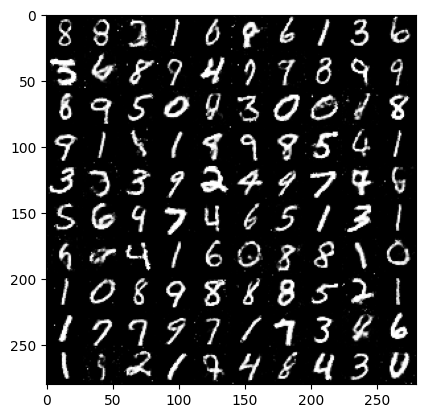

In [142]:
# generation to image
G.eval()
imshow(get_sample_image(G, n_noise), cmap='gray')

In [143]:
# Saving params.
torch.save(D.state_dict(), 'D.pkl')
torch.save(G.state_dict(), 'G.pkl')

## Backup

In [144]:
# from google.colab import drive
# drive.mount('/content/drive')

In [145]:
!pwd && ls

/content
D.pkl  drive  G.pkl  sample_data  samples


In [148]:
! cp samples/vanilla-GAN-100-epoch-symetric_step15000.jpg /content/drive/MyDrive/Deep_Learning_with_CUDA/Lab05/logs/
! cp samples/vanilla-GAN-100-epoch-symetric_step35000.jpg /content/drive/MyDrive/Deep_Learning_with_CUDA/Lab05/logs/
! cp samples/vanilla-GAN-100-epoch-symetric_step65000.jpg /content/drive/MyDrive/Deep_Learning_with_CUDA/Lab05/logs/
! cp samples/vanilla-GAN-100-epoch-symetric_step93000.jpg /content/drive/MyDrive/Deep_Learning_with_CUDA/Lab05/logs/

In [149]:
! cp samples/vanilla-GAN-100-epoch-symetric_step75000.jpg /content/drive/MyDrive/Deep_Learning_with_CUDA/Lab05/logs/

## Fréchet Inception Distance (FID)


Fréchet Inception Distance (FID) is a metric used to measure the similarity between two sets of images. It's particularly popular in the field of generative adversarial networks (GANs), where it's used to evaluate the quality of generated images compared to real ones.


1. Fréchet Distance: The Fréchet distance is a measure of similarity between two probability distributions in a metric space. In the context of FID, these distributions represent the feature vectors of real and generated images.
2. Inception Network Features: To compute FID, you first need to extract features from both real and generated images. Typically, you use a pre-trained Inception network, a convolutional neural network (CNN) originally trained for image classification tasks. The activations of one of the intermediate layers of this network serve as feature representations of the images.
3. Mean and Covariance: Once you have the feature representations of the real and generated images, you compute the mean and covariance matrix for each set of features.
4. Fréchet Distance Calculation: With the mean and covariance of both sets of features computed, you calculate the Fréchet distance between these multivariate Gaussian distributions. The formula for Fréchet distance involves the Euclidean distance between the mean vectors and the trace of the sum of the covariance matrices, along with some matrix operations.
5. FID Score: The final FID score is obtained by computing the Fréchet distance between the two distributions of features.

In summary, FID quantifies how similar the feature distributions of real and generated images are. A lower FID score indicates better similarity and thus better image quality in terms of visual realism and diversity.




## Summary

### Difrent Batch Sizes results for 32, 64, 128

<br/>
<center>
  <h2> Batch Size = 128 | step 7000 </h2>
  <br/>
  <img src="https://lh3.googleusercontent.com/drive-viewer/AKGpihYYiDg1IF5rRZJjRCbFavYt9svSSwI0HLya7YLhc9so2795f_j5J-lseVH3GDB7b0hmwk3azZ_KaiF5tUEr-lOz0ZXgrE6woAY=s2560" />
  <p> Plenty of noise around. It's hard even for human to determin what number was generated
  </p>

  ___
</center>

<center>
  <h2> Batch Size = 64 | step 14000 </h2>
  </br>
  <img src="https://lh3.googleusercontent.com/drive-viewer/AKGpihZEJzludBep589_4yqB8Dl9KMhlqcEJg9-J4fozaUigSLzm-6DZYUqHaClyb2grhbSbdXnBNKnw9sNcq0Av647_e8i_P2o8tVI=s2560" />
  <p> Noise is present but not as much as for batch size = 128. Numbers are more readable  
  </p>
  
  ____
</center>

<center>
  <h2> Batch Size = 32 | step 28000 </h2>
  </br>
  <img src="https://lh3.googleusercontent.com/drive-viewer/AKGpihZ5Iic8owAU7EocYP26GFjIMV9FgGhpQreZZNOVj42fYMv4w9YvUoHw5AIwSST-6iQVvrNbrdBTnmd8y8e9PvMGrvsDOXFPn4A=s2560" />
  <p> Whereas noise is almost not present actual numbers seem to be less readable than for bs = 64 - probably few more epochs would do well for it
  </p>
</center>


### Change in Generator performance

Change in generator performance can determined visually in 2 simple ways:
- Numbers look more real
- Descriptor has problems with finding fake one <-- generator goal


___
- Black regions in the generated images can be interpreted as areas where the generator has successfully generated content that the discriminator does not recognize as fake.

- White regions in the generated images can be interpreted as areas where the discriminator has confidently recognized the content as fake.

<table style="border-collapse: collapse; width: 100%;">
  <tr>
    <td style="padding: 10px;">
      <p> Batch Size 64 - Step 2000 </p>
      <img src="https://lh3.googleusercontent.com/drive-viewer/AKGpiha1_a4esTNRzeEJB2jHELJWAwBi_rS8dFtH7S16oK8OdfjwXTZFJcGAHplPlPDqMZtGwfUy8DZz56qIAT3lbM21tzvdu22pNQ=s2560" style="max-width: 300px;"/>
    </td>
    <td style="padding: 10px;">
      <p> Batch Size 64 - Step 9000 </p>
      <img src="https://lh3.googleusercontent.com/drive-viewer/AKGpihZegnTfZkt4ehnbg72gpv7LNLcFliZ6BeZVTE3PwkVQ2sg39k3glMKPtP37bdVIFlGFTfxCXndl-UG128BRXuLZF6Hyk2BRlg=s2560" style="max-width: 300px;"/>
    </td>
    <td style="padding: 10px;">
      <p> Batch Size 64 - Step 14000 </p>
      <img src="https://lh3.googleusercontent.com/drive-viewer/AKGpihaxNg_oT6CaGZSvYL0wIOYNQULTeBkdTZWlgVcsI49ygZMKgvODvjLEryzwxGG5b4ZQ1NRt8E9hAQiRIXcu0hwHScT2wx6Q8OQ=s2560" style="max-width: 300px;"/>
    </td>
  </tr>
</table>

There is no easy way to determine if after 14k steps generator will be able to produce output significantly better that discriminator cannot recognize as fake.

For few steps in the very begining (2k) Generator is visibly ahead of discriminator however that is to change later one at steps aroung 9k ( in the middle - ish ) where discriminator is capable of finding many fakes ( ~30% ). After another couple steps G models is capable of generating even better images of hand written images that only few can be recognized as fake.

It is worth noticing that in the very begining of training process G model was generating lots of noice - which is not good obvoiusly - but whats worse is that D model wan incapable of finding that tendency - only after couple thousands of iterations it starts to do so.

## 100 Epochs - Symetric
For this task I'd like to focus on how generated images progress throughout training process.

- Batch size = 64
- symetric

<table style="border-collapse: collapse; width: 100%;">
  <tr>
    <td style="padding: 10px;">
      <p> Batch Size 64 - Step 15k </p>
      <img src="https://lh3.googleusercontent.com/drive-viewer/AKGpihYb95-SJ2GlRkB91LELg4_T1GxCfRx0fzuRbpSKTsH_GLHITUN1xScU1GPy7FV7YoWx-Mp7zD0-b0mPSFJb77GQo1icTTksrSk=s2560" style="max-width: 300px;"/>
    </td>
    <td style="padding: 10px;">
      <p> Batch Size 64 - Step 35k </p>
      <img src="https://lh3.googleusercontent.com/drive-viewer/AKGpihYa9VGBiYM9UMaHRklIStUU0zPxE5XfqzCJpIueVGY_YuprX1Xnoxf06MOEz36jd4gL-c4g9Ewe86yFgQKCA7I7KD-Q0NzSxg=s2560" style="max-width: 300px;"/>
    </td>
    <td style="padding: 10px;">
      <p> Batch Size 64 - Step 65k </p>
      <img src="https://lh3.googleusercontent.com/drive-viewer/AKGpihbHh5B5G3vfh93W-c_zhKVhuslhJyyHZ23MTeyU94MlN8grWJus6SiwMcU57m-Avy8HAVSSuMj9xcLO02zPynGXUgOAGoQbE-M=s2560" style="max-width: 300px;"/>
    </td>
  </tr>
</table>
<table style="border-collapse: collapse; width: 100%;">
  <tr>
    <td style="padding: 10px;">
      <p> Batch Size 64 - Step 75k </p>
      <img src="https://lh3.googleusercontent.com/drive-viewer/AKGpihY9mcFqn6ql6xkhj_F0GqJr0Ou4l3Sa4WAoXFIiCKtUc11O64tTNbc_jPZcZETJyfW1vHLaQQ2L9hbwSQ6JGAxZXbh4RnKTmX8=s2560" style="max-width: 300px;"/>
    </td>
    <td style="padding: 10px;">
      <p> Batch Size 64 - Step 93k </p>
      <img src="https://lh3.googleusercontent.com/drive-viewer/AKGpihbRe74W5kVG3tjOmBMgpa5sPKZ6qpjjcEO-Dx2H1ZW1uDnFdatjw0WrPPp86X-Zsirj-QQI1kzXpxFiqAiVJ4cIeC4Ohs5nJg=s2560" style="max-width: 300px;"/>
    </td>
  </tr>
</table>


## Summary

After testing various configurations for training a GAN system on handwritten digit datasets, several conclusions can be drawn to optimize the model's performance.

Firstly, among the tested batch sizes, 64 emerges as the optimal choice. It allows for relatively quick training while still yielding results that are only marginally inferior to those achieved with a batch size of 32.

Introducing asymmetric training strategies reveals that increasing the learning rate of the discriminator proves more effective than boosting the generator's learning rate. However, the improvement in results compared to symmetric training is not substantial.

While enhancing the complexity of the generator may offer potential benefits, it's advisable not to overcomplicate it, as observed in this study. Striking a balance between complexity and efficiency is crucial for achieving satisfactory results.

A consistent observation across all experiments is the occurrence of suboptimal decisions by the discriminator. Therefore, it's worthwhile to explore increasing the frequency of discriminator training iterations relative to the generator. This approach aims to equip the discriminator with better discriminatory abilities, potentially leading to improved image selection during training.

In summary, optimizing the batch size, experimenting with asymmetric training strategies, and carefully calibrating the complexity of the generator are key considerations in developing an effective GAN system for handwritten digit datasets. Moreover, enhancing the discriminator's training frequency may further enhance the model's performance by refining its ability to distinguish between real and generated images.